In [2]:
import sys
packages = [
    '../dataset/',
    '../utils/',
    '../optimizer/',
    '../loss/',
    '../model/'
]
sys.path.extend(packages)

from sklearn.model_selection import KFold
from util import getNowTime
from tqdm import tqdm
from brpnet.model import UNet
from loss import dice_loss, smooth_truncated_loss, compute_loss_list
from adamw_r.cyclic_scheduler import CyclicLRWithRestarts, ReduceMaxLROnRestart
from adamw_r.adamw import AdamW
from ImageProcess.ImgShow import showLineImg
from dataset.PathologyData import PathologyDataSet
from dataset.KumarPatchDataSet import KumarPatchDataSet
import cv2
import torch.nn.functional as F
import time
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
from DataUtil import kfold_list
from postProcess.post_proc import post_proc
from metrics import get_fast_aji,remap_label

# 导入自己定义的一些需要的包
print('获取到的当前是时间： ', getNowTime())



获取到的当前是时间：  2021-01-02_01_49_26


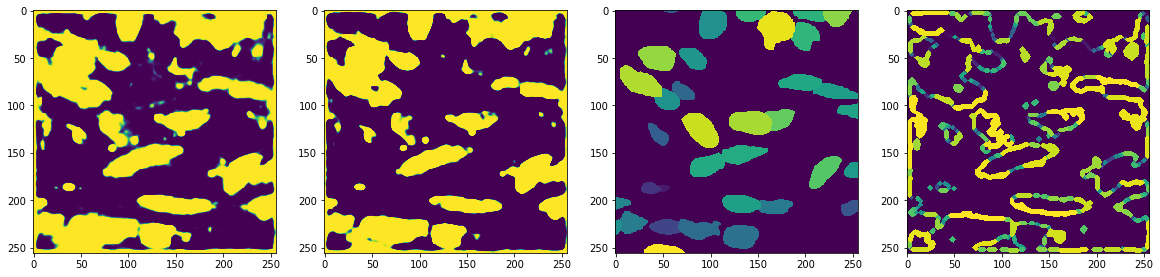

In [7]:
# 做一些小的测试
pred_sout = np.load('pred_sout_69_0.npy')
pred_cout = np.load('pred_cout_69_0.npy')
gt = np.load('gt_label0_69_0.npy')


postProcImg = post_proc(pred_sout - pred_cout, post_dilation_iter=2)

showLineImg([pred_sout,pred_cout,gt,postProcImg],figsize=(20,20))



ipykernel_launcher:22: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
144


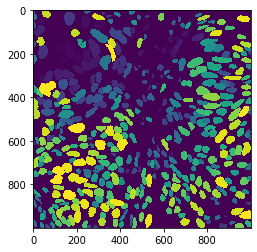

In [3]:
# 获取数据

imgs = np.load('../dataset/kumarDataset/train/trainDataSet.npy')
labels = np.load('../dataset/kumarDataset/labels/labelDataSet.npy')
bounds = np.load('../dataset/kumarDataset/bounds/boundDataSet.npy')

# 对数据进行划分
folds = 4
train_idxs,val_idxs = kfold_list(imgs.shape[0],folds)
# 一共有16张图片，每张图片的大小是1000*1000
# 一些超参数的设置
CFG = {
    "batch_size": 8,
    "num_epoch":10,
    # 不同损失所占的额权重比
    "dice_weight":0.5
}
imgs_val = imgs[val_idxs[0]]
labels_val = labels[val_idxs[0]]

imgs_val = np.transpose(imgs_val,(0,3,1,2)) # 训练的图像的数据
labels_val = np.expand_dims(labels_val,4)
labels_val = labels_val.transpose(0,3,1,2) # 训练的标签的数据

val_dataset = KumarPatchDataSet(imgs_val,labels_val)
val_dataloader = DataLoader(val_dataset,shuffle=False,batch_size=2)
print(len(val_dataset))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(3,1,1).to(device)
model.load_state_dict(torch.load('../train_model/segModel_800.pth'))

plt.imshow(labels[0])




  0%|          | 0/72 [00:00<?, ?it/s]index:  0
图像的尺寸：  torch.Size([3, 256, 256])
index:  1
图像的尺寸：  torch.Size([3, 256, 256])
0.8716119167863596



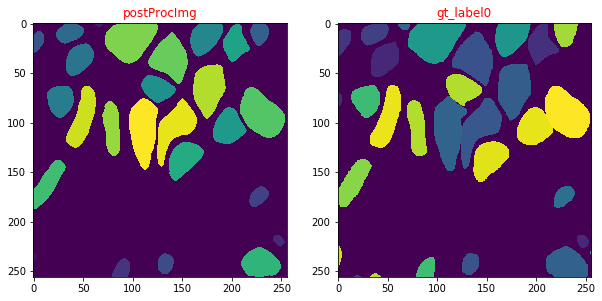

In [4]:
def calculateAJI(pred,gt_lbl):
    aji = get_fast_aji(remap_label(gt_lbl), remap_label(pred))
    return aji

def getPostProcImg(sout,cout):
    return post_proc(sout-cout, post_dilation_iter=2)

def valid(model,device,dataloader,lossfn):
    sigmod = nn.Sigmoid()
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for index,(images,labels) in pbar:
        b, c, h, w = images.shape
        images = images.to(device)
        sout, sout_0, sout_1, sout_2, sout_3, cout, cout_0, cout_1, cout_2, cout_3 = model(images)
        pred_sout = sigmod(sout[0][0]).cpu().data.numpy()
        pred_cout = sigmod(cout[0][0]).cpu().data.numpy()
        gt_label0 = labels[0][0].cpu().data.numpy()

        postProcImg = getPostProcImg(pred_sout,pred_cout)
        aji = calculateAJI(gt_label0,postProcImg)
        print(aji)
        showLineImg([postProcImg,gt_label0],title=['postProcImg','gt_label0'])
        # print(image0.shape,image1.shape)
        # cv2.imwrite('image0.jpg',image0)
        # cv2.imwrite('image1.jpg',image1)
        break


valid(model,device,val_dataloader,compute_loss_list)




In [11]:
del model,val_dataset,val_dataloader
torch.cuda.empty_cache()

In [4]:
import numpy as np

a = np.array([0.6326388888888889, 0.658331948828709, 0.5852475519355724, 0.5564272288959712, 0.5299431247909, 0.5538063909774437, 0.5494899365867107, 0.554553264604811, 0.6402439024390244, 0.5503916449086161, 0.49746478873239436, 0.6078151260504202, 0.5642392251319633, 0.5800735713175483, 0.5906113537117904, 0.5250188205771643, 0.5577204805156754, 0.6365202411714039, 0.5570099114776424, 0.5553751676431142, 0.5406185013751929, 0.5626623872841204, 0.547578277886497, 0.6026085915998564, 0.4921895006402049, 0.5217550274223035, 0.5381900967558338, 0.5256064690026954, 0.43863898500576703, 0.5175837815473727, 0.5744256915142991, 0.5343289371605896, 0.5460747573748439, 0.5931846463099454, 0.5725982532751092, 0.46590989712664066, 0.5493170972519336, 0.498408325681053, 0.49431399065650355, 0.5157708558514297, 0.4631456181272909, 0.5224426834432279, 0.4982642434143353, 0.5564005069708492, 0.5625170346143363, 0.5351250749187723, 0.4900818994665264, 0.546612365790448, 0.5011048448270176, 0.4739168179307079, 0.4168771227031264, 0.4087749427543343, 0.40862839179351423, 0.4830817069678, 0.48485545939974223, 0.3655254777070064, 0.411079622656159, 0.39885128205128206, 0.41684448349441444, 0.4761304895530168, 0.413838303450213, 0.3973290352291043, 0.4062334487675698, 0.41558543681685933, 0.46925448203131337, 0.5812099247281851, 0.35479845928497805, 0.37921961596596315, 0.3361093791752026, 0.34959899071821215, 0.40011964278084006])
print(a)
print(np.mean(a))


[0.63263889 0.65833195 0.58524755 0.55642723 0.52994312 0.55380639
 0.54948994 0.55455326 0.6402439  0.55039164 0.49746479 0.60781513
 0.56423923 0.58007357 0.59061135 0.52501882 0.55772048 0.63652024
 0.55700991 0.55537517 0.5406185  0.56266239 0.54757828 0.60260859
 0.4921895  0.52175503 0.5381901  0.52560647 0.43863899 0.51758378
 0.57442569 0.53432894 0.54607476 0.59318465 0.57259825 0.4659099
 0.5493171  0.49840833 0.49431399 0.51577086 0.46314562 0.52244268
 0.49826424 0.55640051 0.56251703 0.53512507 0.4900819  0.54661237
 0.50110484 0.47391682 0.41687712 0.40877494 0.40862839 0.48308171
 0.48485546 0.36552548 0.41107962 0.39885128 0.41684448 0.47613049
 0.4138383  0.39732904 0.40623345 0.41558544 0.46925448 0.58120992
 0.35479846 0.37921962 0.33610938 0.34959899 0.40011964]
0.5075808933442296


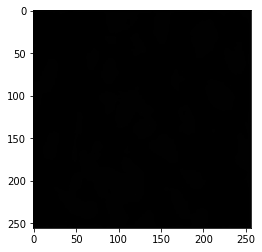

In [3]:
# 测试一些代码的结果
import cv2
import numpy as np
import matplotlib.pyplot as plt

pred_sout = cv2.imread('pred_sout.jpg')

plt.imshow(pred_sout)
plt.show()

In [4]:
pred_sout.shape

(256, 256, 3)